# Joint Inference and Learning with SING

In this notebook, we provide a demonstration of how the SING algorithm can be used to perform joint inference and learning in latent SDE models. Compared to previous variational inference methods for latent SDE models, **SING performs faster and more stable latent state inference, which translates to improvements in prior drift estimation and parameter learning**. We validate that SING enables effective parameter learning across numerous drift classes: neural network and polynomial basis drift as well as nonparametric Gaussian process prior drift.

## Set-up

### Load in the SING codebase

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Jax imports
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import vmap
from jax import random as jr

# Other imports
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

from functools import partial

# Plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

# SING imports
from sing.plotting import *
from sing.sde import DuffingOscillator
from sing.simulate_data import simulate_sde, simulate_gaussian_obs
from sing.initialization import initialize_params_pca
from sing.likelihoods import Gaussian

In [3]:
# Check that we are on GPU
print(jax.devices())

[CudaDevice(id=0)]


### Generate Data

For this notebook, we work with latent variables generated according to the unforced Duffing equation
\begin{align*}
\frac{d^2 v}{dt^2} + \gamma \frac{d v}{dt} - \alpha v + \beta v^3 = 0,
\end{align*}
which is a second-order ordinary differential equation.

If we define $\boldsymbol{x} \in \mathbb{R}^2$ such that $\boldsymbol{x}_1 = v$ and $\boldsymbol{x}_2 = \frac{dv}{dt}$, then we obtain the system of first-order ordinary differential equations
\begin{equation}\tag{$\star$}
\begin{aligned}
&\frac{d\boldsymbol{x}_1}{dt} = \boldsymbol{x}_2\\
&\frac{d\boldsymbol{x}_2}{dt} = \alpha \boldsymbol{x}_1 - \beta \boldsymbol{x}_1^3 - \gamma \boldsymbol{x}_2.
\end{aligned}
\end{equation}
When $\alpha / \beta  > 0$, the Duffing equation has two stable fixed points at $\boldsymbol{x} =(\pm \sqrt{\alpha / \beta}, 0)$ in addition to an unstable fixed point at $\boldsymbol{x} = (0, 0)$. We generate two-dimensional latent trajectories according the SDE with drift defined according to the Duffing equation $(\star)$ with $(\alpha, \beta, \gamma) = (2, 1, 0.1)$ and diffusion coefficient $\sigma = 0.2$. We generate four trajectories from near the rightmost fixed point, $(\sqrt{2}, 0)$, with $T_{\text{max}} = 15$ and uniform discretization grid $\Delta t = 0.015$.

We consider $10$-dimensional outputs $\boldsymbol{y}(\tau_i) \sim \mathcal{N}(\boldsymbol{y}(\tau_i) | \boldsymbol{C}\boldsymbol{x}(\tau_i) + \boldsymbol{d}, \boldsymbol{R})$, for $\boldsymbol{C} \in \mathbb{R}^{10 \times 2}, \boldsymbol{d} \in \mathbb{R}^2$ and $\boldsymbol{R} \in \mathbb{R}^{10 \times 10}$ a diagonal matrix. We generate observations at a random $n = 300$ of the total $T = 1000$ timesteps, and observations are generated independently of one another. 

In [4]:
# True drift function
sde = DuffingOscillator()
sde_params = {'alpha': jnp.array([2.0]), 'beta': jnp.array([1.0]), 'gamma': jnp.array([0.1]), 'drift_scale': 1.}
drift_fn_true = partial(sde.drift, sde_params, t=None)

# Initial conditions
fp = 1.414
delt = 0.1
x0s = jnp.array([[fp - delt, delt]])
x0s = x0s.repeat(4, axis=0)
n_trials = x0s.shape[0]

# Instantiate (true) output parameters with i.i.d. normal entries 
latent_dim= 2
output_dim = 10
key_out = jr.PRNGKey(0)
key_C, key_d = jr.split(key_out, 2)
output_params = {
    'C': tfd.Normal(0, 1).sample(seed=key_C, sample_shape=(output_dim, latent_dim)),
    'd': tfd.Normal(0, 1).sample(seed=key_d, sample_shape=(output_dim,)),
    'R': 0.1 * jnp.ones(output_dim)
}

In [5]:
# Random key for sampling latent trajectories and observations
key = jr.PRNGKey(1)

n_timesteps = 1000
n_obs = 300
t_max = 15.0
sigma = 0.2

key_xs, key_obs, key_mask = jr.split(key, 3)
key_xs = jr.split(key_xs, n_trials)

# Generate ground truth latent trajectories
xs = vmap(partial(simulate_sde, f=partial(sde.drift, sde_params), t_max=t_max, n_timesteps=n_timesteps, sigma= lambda x, t: sigma * jnp.eye(latent_dim)))(key_xs, x0s)
    
# Generate observations on dense grid
ys_dense = vmap(partial(simulate_gaussian_obs, output_params=output_params))(jr.split(key_obs, n_trials), xs)

# Select n_obs observations at random to be included in each trial
def make_mask(k):
    idx = jr.choice(k, n_timesteps, shape=(n_obs,), replace=False)
    return jnp.zeros(n_timesteps, dtype=bool).at[idx].set(True)
t_mask = vmap(make_mask)(jr.split(key_mask, n_trials)) 
ys = ys_dense * t_mask[...,None]

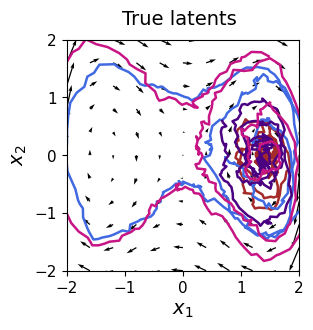

In [6]:
# Now, visualize true latents
fontsize = 14
labelsize = 11
fig, ax = plt.subplots(figsize=(3, 3))
ax = plot_dynamics_and_latents_2d(drift_fn_true, latents=None, xlim=(-2, 2), ylim=(-2, 2), n_xpts=11, n_ypts=11, ax=ax)

cols = ['brown', 'royalblue', 'indigo', 'mediumvioletred']
skip = 4
for i, idx in enumerate(range(n_trials)):
    ax.plot(xs[idx,::skip,0], xs[idx,::skip,1], lw=1.8, color=cols[i])
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)

fig.suptitle('True latents', fontsize=fontsize)
plt.show()

## Variational Expectation-Maximization (vEM)

As was the case when performing inference, our prior is a (nonlinear) SDE
\begin{align*}
p: d\boldsymbol{x}(t) = \boldsymbol{f}(\boldsymbol{x}(t), t | \boldsymbol{\theta})dt + \sigma d \boldsymbol{w}(t), \quad p(\boldsymbol{x}(0)) = \mathcal{N}(\boldsymbol{\mu}_0, \boldsymbol{V}_0),
\end{align*}
where $\boldsymbol{\theta}$ are the parameters of the prior drift. Our variational posterior is a linear, time varying SDE
\begin{align*}
q: d\boldsymbol{x}(t) = \{ \boldsymbol{A}(t) \boldsymbol{x}(t) + \boldsymbol{b}(t) \}dt + \sigma d \boldsymbol{w}(t), \quad q(\boldsymbol{x}(0)) = \mathcal{N}(\boldsymbol{m}(0), \boldsymbol{S}(0)).
\end{align*}
In addition to the prior drift parameters, we would like to learn the output parameters $\{\boldsymbol{C}, \boldsymbol{d}, \boldsymbol{R}\}$ as well as the mean and covariance of the prior at time $t = 0$, $\boldsymbol{\mu}_0$ and $\boldsymbol{V}_0$, respectively. Altogether, the parameters of the model are $\boldsymbol{\Theta} = \{\boldsymbol{\theta}, \boldsymbol{C}, \boldsymbol{d}, \boldsymbol{R}, \boldsymbol{\mu}_0, \boldsymbol{V}_0\}$. The parameters of the variational posterior, i.e. variational parameters, are the functions $\{(\boldsymbol{A}(t))_{0 \leq t \leq T_{\text{max}}}, (\boldsymbol{b}(t))_{0 \leq t \leq T_{\text{max}}} \}$.

Next, we perform the variational expectation-maximization (vEM) algorithm, which alternates between (i) fixing $\boldsymbol{\Theta}$ and maximizing the ELBO with respect to the variational parameters (the **variational E-step**); and (ii) fixing the variational parameters and maximizing the ELBO with respect to $\boldsymbol{\Theta}$ (the **M-step**).

In [7]:
# Initialize output parameters using PCA
output_params_init, x0_init_params = initialize_params_pca(2, ys)

# Initialize the prior mean and variance for x0 to first PC score and I
init_params = {
    'mu0': x0_init_params,
    'V0': jnp.eye(latent_dim)[None].repeat(n_trials, 0)
}

# Initialize the model likelihood 
t_grid = jnp.linspace(0, t_max, n_timesteps)
likelihood = Gaussian(ys, t_mask)

# Initialize the prior mean and variance for x0 to the first two PC scores and identity, respectively
init_params = {
    'mu0': x0_init_params,
    'V0': jnp.eye(latent_dim)[None].repeat(n_trials, 0)
}

### Gaussian Process Prior

First, we consider modeling the prior drift as a Gaussian process (GP) with mean zero and radial basis function (RBF) kernel: 
\begin{align*}
\boldsymbol{f} \sim \mathcal{GP}(0, k_{\text{RBF}}(\cdot, \cdot)), \quad k_{\text{RBF}}(\boldsymbol{w}, \boldsymbol{z}) := \kappa \exp\left\{ 
    - \left(\boldsymbol{w}_1 -  \boldsymbol{z}_1\right)^2/(2\ell_1^2) - \left(\boldsymbol{w}_2 -  \boldsymbol{z}_2\right)^2 / (2\ell_2^2) \right\}, \ \boldsymbol{w}, \boldsymbol{z} \in \mathbb{R}^2.
\end{align*}
$\kappa \geq 0$ represents the output scale, and $\ell_1, \ell_2$, called the length-scales, determine how fast the correlation between points $\boldsymbol{w}, \boldsymbol{z}$ decays along each dimension. In addition to inferring an approximate posterior over latents $(\boldsymbol{x}(t))_{0 \leq t \leq T_{\text{max}}}$, we will infer an approximate posterior over $\boldsymbol{f}$ using the sparse variational Gaussian processes framework [1, 2].

**References:**

[1] Duncker, L., Bohner, G., Boussard, J., & Sahani, M. (2019). Learning interpretable continuous-time models of latent stochastic dynamical systems. In International conference on machine learning, PMLR, 1726–1734.

[2] Titsias, M. (2009). Variational learning of inducing variables in sparse gaussian processes. In Artificial intelligence and statistics, PMLR, 567–574.


In [8]:
from sing.sde import SparseGP
from sing.kernels import RBF

To determine the grid of inducing points, we look at the first two principal components of the observations:

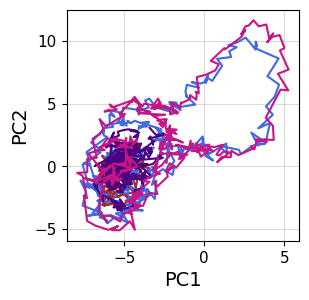

In [9]:
# Check scale of latents in PCA
selected = ys[t_mask.astype(bool)].reshape(n_trials, n_obs, output_dim) 
xs_pca = (selected - output_params_init['d']) @ output_params_init['C']

fig, ax = plt.subplots(figsize=(3, 3))
for i in range(n_trials):
    ax.plot(xs_pca[i,:,0], xs_pca[i,:,1], color=cols[i])
ax.set_xlabel("PC1", fontsize=fontsize)
ax.set_ylabel("PC2", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)

plt.show()

Looking at the plot of the PC scores, we will choose our Gaussian process inducing points to be defined on the grid $[-6, 6] \times [-6, 6]$. This is simply a heuristic, as we will also be learning $\{\boldsymbol{C}, \boldsymbol{d}\}$.

In [10]:
# Initialize the RBF kernel of the GP prior
kernel = RBF()

# Initialize kernel hyperparameters
kernel_params_init = {
    'length_scales': jnp.ones(latent_dim),
    'output_scale': 1.,
}

# Grid of inducing points
zs = jnp.meshgrid(
    jnp.linspace(-6, 6, 12),
    jnp.linspace(-6, 6, 12)
)
zs = jnp.column_stack([zs[0].ravel(), zs[1].ravel()])

# Instantiate the Gaussian prior
fn = SparseGP(zs, kernel)

We now fit the variational EM algorithm for $50$ total iterations. We perform $10$ SING updates and $50$ M-steps per vEM iteration.

In [11]:
key = jr.PRNGKey(2)
from sing.sing import fit_variational_em

n_iters = 50 # vEM iterations
n_iters_e = 10 # E-steps i.e. SING updates
n_iters_m = 50 # M-steps

# Schedule for SING learning rate
rho_sched_0 = jnp.logspace(-3, -2, 10)
rho_sched_1 = rho_sched_0[-1] * jnp.ones(n_iters - len(rho_sched_0))
rho_sched = jnp.concatenate([rho_sched_0, rho_sched_1])

# Schedule for M-step learning rate (M-step is performed using Adam)
learning_rate = 1e-4 * jnp.ones(n_iters)

# NOTE: batch_size = None means no mini batching is used
results_sing_GP = fit_variational_em(key,
                                     fn,
                                     likelihood,
                                     t_grid,
                                     kernel_params_init,
                                     init_params,
                                     output_params_init,
                                     batch_size=None,
                                     rho_sched=rho_sched,
                                     sigma=sigma,
                                     n_iters=n_iters,
                                     n_iters_e=n_iters_e,
                                     perform_m_step=True,
                                     n_iters_m=n_iters_m,
                                     learning_rate=learning_rate)

Initializing params...
Performing variational EM algorithm...
Iteration 1 / 50, ELBO: -14093.092473489085, ell: -13890.584044964362, KL: 157.43701476776187, prior: -45.07141375696132
Iteration 2 / 50, ELBO: -13747.563386264912, ell: -13550.845854073284, KL: 151.97715218239682, prior: -44.74038000922988
Iteration 3 / 50, ELBO: -13300.95535039134, ell: -13105.572686803447, KL: 150.90532406621787, prior: -44.47733952167374
Iteration 4 / 50, ELBO: -12742.122043914313, ell: -12542.095258348592, KL: 155.57812588963498, prior: -44.448659676084446
Iteration 5 / 50, ELBO: -12072.519165183257, ell: -11861.010961596883, KL: 166.65525346681898, prior: -44.852950119556084
Iteration 6 / 50, ELBO: -11293.62238325018, ell: -11064.554947767167, KL: 182.9658918191708, prior: -46.10154366384312
Iteration 7 / 50, ELBO: -10394.885112276286, ell: -10143.270347893424, KL: 203.05386387653562, prior: -48.5609005063267
Iteration 8 / 50, ELBO: -9364.955517436838, ell: -9086.500127748746, KL: 226.94655245218746, 

In [12]:
# unpack results
marginal_params_GP, _, gp_post, drift_params_GP, init_params_GP, output_params_GP, _, elbos_GP = results_sing_GP

Since we are learning the output parameters $\{\boldsymbol{C}, \boldsymbol{d}\}$ together with the latent variables $(\boldsymbol{x}(t))_{0 \leq t \leq 1}$, the learned subspace may not match the true generative subspace. Thus, we need to map the latent space we learned to the true latent space.

In [13]:
from sing.utils.general_helpers import get_transformation_for_latents

# Compute the matrix P and offset vector
ms_final, Ss_final, _ = marginal_params_GP
P, offset = get_transformation_for_latents(output_params['C'], output_params['d'], output_params_GP['C'], output_params_GP['d'])
ms_final = vmap(vmap(lambda x: P @ x + offset))(ms_final)
Ss_final = vmap(vmap(lambda x: P @ x @ P.T))(Ss_final)

First, visualize the posterior mean and variance of the latents, plotted against the ground truth latents:

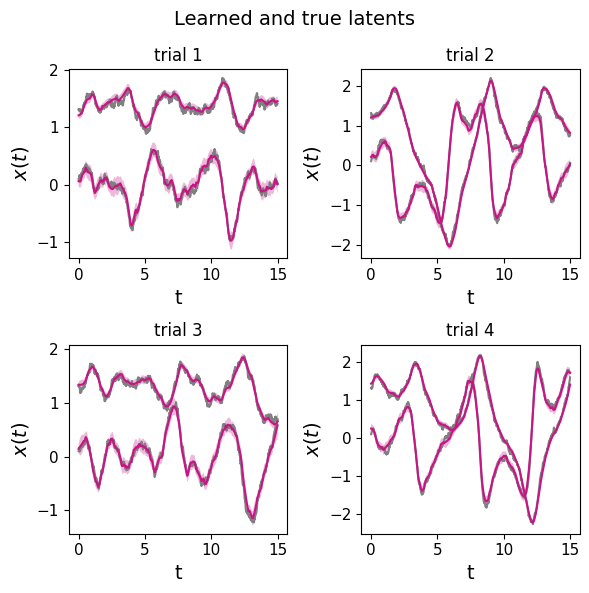

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for i, ax in enumerate(axs.ravel()):
    plot_latents_over_time(t_grid, xs[i], latents_cov=None, color='gray', ax=ax, fontsize=fontsize)
    plot_latents_over_time(t_grid, ms_final[i], Ss_final[i], color='mediumvioletred', alpha=0.3, ax=ax, fontsize=fontsize),
    ax.tick_params(axis='both', labelsize=labelsize)
    ax.set_title(f'trial {i+1}')

fig.suptitle("Learned and true latents", fontsize=fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # shift subplot area down so the suptitle doesn’t overlap

fig.tight_layout()
plt.show()

Next, we visualize the posterior mean and variance of the drift. Since the posterior variance is a $2 \times 2$ matrix, we compute its determinant. Note that in the true latent space, the posterior variance will not necessarily be diagonal (although, by construction, it is diagonal in the **inferred** latent space).

In [15]:
# Transform the posterior mean vector field
f_trans = transform_vector_field(lambda x: fn.get_posterior_f_mean(gp_post, drift_params_GP,x[None])[0],dim=latent_dim, P=P, offset=offset)

# Similarly, transform the posterior variance
def posterior_f_var_trans(x):
    x_inf = jnp.linalg.solve(P, x - offset)
    cov_inf = fn.get_posterior_f_var(gp_post, drift_params_GP, x_inf[None])[0]
    cov_true = P @ cov_inf @ P.T
    return jnp.linalg.det(cov_true)

In [16]:
def plot_dynamics_variance_2d_modified(dynamics_var_fn, xlim=(-2, 2), ylim=(-2, 2), n_xpts=100, n_ypts=100, fig=None, ax=None, figsize=(4, 4), fontsize=12):
    """
    Helper function for plotting the posterior variance of the GP drift
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    xs = jnp.linspace(*xlim, n_xpts)
    ys = jnp.linspace(*ylim, n_ypts)
    xg, yg = jnp.meshgrid(xs, ys)
    xy_flat = jnp.stack([xg.ravel(), yg.ravel()]).T

    fs_var = jnp.array(vmap(dynamics_var_fn)(xy_flat))
    fs_var = fs_var.reshape(n_ypts, n_xpts)

    base = plt.cm.Purples
    crop_end = 0.7 # Crop out the darkest colors to make dynamics visible
    light_colors = base(jnp.linspace(0.0, crop_end, 256))
    light_cmap = colors.LinearSegmentedColormap.from_list(
        'light_purples_top', light_colors
    )
    pcm = ax.pcolormesh(xg, yg, fs_var, norm=colors.LogNorm(vmin=fs_var.min(), vmax=fs_var.max()), cmap=light_cmap, shading='gouraud') # use smooth shading

    ax.set_aspect('equal', 'box')
    return fig, ax, pcm

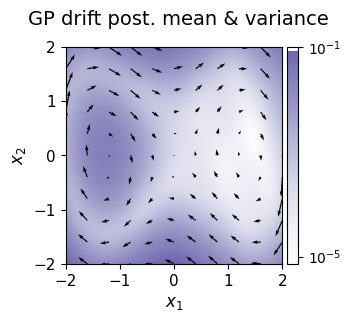

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))
_, _, pcm = plot_dynamics_variance_2d_modified(posterior_f_var_trans, fig=fig, ax=ax, xlim=(-2, 2), ylim=(-2, 2))
plot_dynamics_and_latents_2d(f_trans, latents=None, n_xpts=11, n_ypts=11, xlim=(-2, 2), ylim=(-2,2), ax=ax)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.tick_params(axis='both', labelsize=labelsize)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pcm, cax=cax)

ticks = [1e-1, 1e-5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([r"$10^{-1}$", r"$10^{-5}$"])
cbar.ax.tick_params(labelsize=labelsize)

cbar.ax.yaxis.set_minor_locator(ticker.NullLocator())
cbar.ax.set_yticklabels([r'$10^{-1}$', r'$10^{-5}$'], fontsize=10)

fig.suptitle('GP drift post. mean & variance', fontsize=fontsize)
plt.show()

As we would hope, the GP posterior mean resembles the true unforced Duffing equation. Moreover, the GP posterior has the smallest variance near the rightmost fixed point $(\sqrt{2}, 0)$ where we initialize the latent trajectories.

### Neural Network Prior Drift

Next, we try performing joint inference and learning when the prior drift $\boldsymbol{f}$ is modeled as a neural network. In particular, we consider a simple multi-layer perceptron (MLP) with two hidden layers of size $64$ and ReLU activations.

In [18]:
from sing.sde import MLP, NeuralSDE

Fit variational EM using SING:

In [19]:
# Initialize NN 
model = MLP(features=[64,64], latent_dim=latent_dim)

##  Initialize NN parameters
model_key = jr.PRNGKey(3)
x0 = jnp.zeros((1, latent_dim))
t0 = jnp.zeros((1,))
network_params = model.init(model_key, x0, t0)
sde_params = {
    'network_params': network_params,
}

fn = NeuralSDE(apply_fn=model.apply, latent_dim=latent_dim, n_quad=16)
print(f"NN drift at (x0, t0): {fn.drift(sde_params, x0, t0)}")

NN drift at (x0, t0): [[0. 0.]]


In [20]:
key = jr.PRNGKey(3)
n_iters = 50
n_iters_e = 10
n_iters_m = 50

rho_sched_0 = jnp.logspace(-3, -2, 10)
rho_sched_1 = rho_sched_0[-1] * jnp.ones(n_iters - len(rho_sched_0))
rho_sched = jnp.concatenate([rho_sched_0, rho_sched_1])
learning_rate = 1e-3*jnp.ones(n_iters)

results_sing_NSDE = fit_variational_em(key,
                                       fn,
                                       likelihood,
                                       t_grid,
                                       sde_params,
                                       init_params,
                                       output_params_init,
                                       batch_size=None,
                                       rho_sched=rho_sched, 
                                       sigma=sigma, 
                                       n_iters=n_iters, 
                                       n_iters_e=n_iters_e, 
                                       perform_m_step = True, 
                                       n_iters_m=n_iters_m, 
                                       learning_rate=learning_rate)

Initializing params...
Performing variational EM algorithm...
Iteration 1 / 50, ELBO: -15427.391279886917, ell: -15222.87942732793, KL: 204.511852558986, prior: 0.0
Iteration 2 / 50, ELBO: -15181.350997757372, ell: -14976.897268293747, KL: 204.45372946362477, prior: 0.0
Iteration 3 / 50, ELBO: -14828.38818739546, ell: -14612.97760076134, KL: 215.41058663411968, prior: 0.0
Iteration 4 / 50, ELBO: -14303.804533723733, ell: -14076.12676961634, KL: 227.67776410739316, prior: 0.0
Iteration 5 / 50, ELBO: -13580.100698385175, ell: -13339.932570579678, KL: 240.16812780549662, prior: 0.0
Iteration 6 / 50, ELBO: -12718.147931654894, ell: -12465.208347998734, KL: 252.9395836561598, prior: 0.0
Iteration 7 / 50, ELBO: -11787.182842081344, ell: -11511.719082543292, KL: 275.4637595380518, prior: 0.0
Iteration 8 / 50, ELBO: -10751.376720193999, ell: -10453.663138275962, KL: 297.71358191803665, prior: 0.0
Iteration 9 / 50, ELBO: -9569.123710028025, ell: -9237.314411511585, KL: 331.8092985164403, prior:

In [21]:
# unpack results
marginal_params_NSDE, _, _, drift_params_NSDE, init_params_NSDE, output_params_NSDE, _, elbos_NSDE = results_sing_NSDE

In [22]:
# Compute the matrix P and offset vector
ms_final, Ss_final, _ = marginal_params_NSDE
P, offset = get_transformation_for_latents(output_params['C'], output_params['d'], output_params_NSDE['C'], output_params_NSDE['d'])
ms_final = vmap(vmap(lambda x: P @ x + offset))(ms_final)
Ss_final = vmap(vmap(lambda x: P @ x @ P.T))(Ss_final)

Plot inferred latents against ground truth latents:

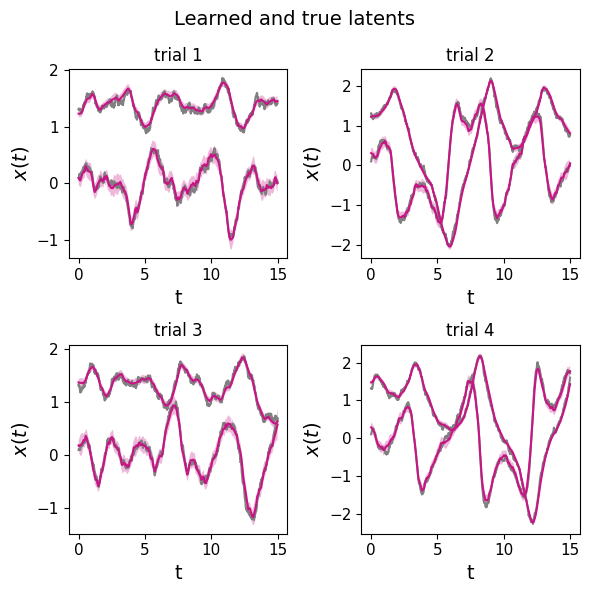

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for i, ax in enumerate(axs.ravel()):
    plot_latents_over_time(t_grid, xs[i], latents_cov=None, color='gray', ax=ax, fontsize=fontsize)
    plot_latents_over_time(t_grid, ms_final[i], Ss_final[i], color='mediumvioletred', alpha=0.3, ax=ax, fontsize=fontsize),
    ax.tick_params(axis='both', labelsize=labelsize)
    ax.set_title(f'trial {i+1}')

fig.suptitle("Learned and true latents", fontsize=fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # shift subplot area down so the suptitle doesn’t overlap

fig.tight_layout()
plt.show()

And visualize the learned prior drift function:

In [24]:
f_trans = transform_vector_field(lambda x: fn.drift(drift_params_NSDE, x[None], None)[0], dim=latent_dim, P=P, offset=offset)

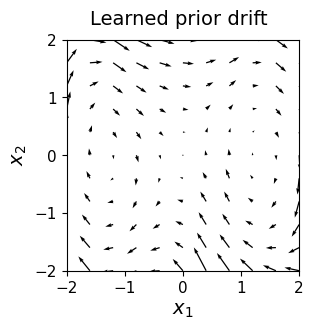

In [25]:
fig, ax = plt.subplots(figsize=(3, 3))
ax = plot_dynamics_and_latents_2d(f_trans, latents=None, ax=ax, n_xpts=11, n_ypts=11, xlim=(-2, 2), ylim=(-2, 2), fontsize=fontsize)
ax.tick_params(axis='both', labelsize=labelsize)

fig.suptitle('Learned prior drift', fontsize=fontsize)
plt.show()

#### Polynomial Basis Prior Drift

Lastly, we consider a polynomial basis drift consisting of all polynomials up to order $3$:
\begin{align*}
\boldsymbol{f}_{i}(\boldsymbol{x} | \boldsymbol{\theta}) = \theta_{0,i} + \theta_{1, i} \boldsymbol{x}_1 + \theta_{2, i} \boldsymbol{x}_2 + \theta_{3, i} \boldsymbol{x}_1^2 + \theta_{4, i} \boldsymbol{x}_2^2 + \theta_{5, i} \boldsymbol{x}_1^2 \boldsymbol{x}_2 + \theta_{6, i} \boldsymbol{x}_1 \boldsymbol{x}_2^2 + \theta_{7, i} \boldsymbol{x}_1^2 \boldsymbol{x}_2^2 + \cdots +  \theta_{15, i} \boldsymbol{x}_1^2 \boldsymbol{x}_2^3, \ i \in \{1, 2\}.
\end{align*}
Here, $\boldsymbol{\theta} \in \mathbb{R}^{16 \times 2}$ (one set of basis functions for each latent dimension) are learnable coefficients on the polynomial basis functions. Observe that the unforced Duffing equation can be perfectly represented as a linear combination of polynomials up to order $3$. In real data examples, this would not be known, of course, and one might need to choose a more expressive basis (e.g., a basis consisting of trigonometric functions with high and low frequencies) to approximate the drift.

In [26]:
from sing.sde import BasisSDE

In [27]:
# Instantiate a prior SDE with polynomial drift
def basis_set(x, t):
    return jnp.array([1., x[0], x[0]**2, x[0]**3, x[1], x[1]**2, x[1]**3, x[0] * x[1], 
    (x[0]**2) * (x[1]**2), (x[0]**2) * x[1], x[0] * (x[1]**2), (x[0]**3) * (x[1]**3), 
    (x[0]**3) * x[1], (x[0]**3) * (x[1]**2), x[0] * (x[1]**3), (x[0]**2) * (x[1]**3)])

weights_key = jr.PRNGKey(4)
sde_params = {'w': tfd.Normal(0, 0.1).sample(seed=weights_key, sample_shape=(latent_dim, 16))}

fn = BasisSDE(basis_set, latent_dim=latent_dim, n_quad=16)

In [28]:
key = jr.PRNGKey(5)
n_iters = 50
n_iters_e = 10
n_iters_m = 50

rho_sched_0 = jnp.logspace(-3, -2, 10)
rho_sched_1 = rho_sched_0[-1] * jnp.ones(n_iters - len(rho_sched_0))
rho_sched = jnp.concatenate([rho_sched_0, rho_sched_1])

learning_rate = jnp.logspace(-2, -5, n_iters)

results_sing_basis = fit_variational_em(key, 
                                        fn, 
                                        likelihood, 
                                        t_grid, 
                                        sde_params, 
                                        init_params, 
                                        output_params_init, 
                                        batch_size=None, 
                                        rho_sched=rho_sched, 
                                        sigma=sigma, 
                                        n_iters=n_iters, 
                                        n_iters_e=n_iters_e, 
                                        perform_m_step = True, 
                                        n_iters_m=n_iters_m, 
                                        learning_rate=learning_rate)

Initializing params...
Performing variational EM algorithm...
Iteration 1 / 50, ELBO: -13600.65888302068, ell: -13062.854237104168, KL: 537.8046459165125, prior: 0.0
Iteration 2 / 50, ELBO: -12925.679565084041, ell: -12552.447624633804, KL: 373.23194045023774, prior: 0.0
Iteration 3 / 50, ELBO: -12272.373924747419, ell: -11939.875958146793, KL: 332.49796660062566, prior: 0.0
Iteration 4 / 50, ELBO: -11549.345934676157, ell: -11237.129509038305, KL: 312.2164256378528, prior: 0.0
Iteration 5 / 50, ELBO: -10767.97267135082, ell: -10466.973583867944, KL: 300.99908748287635, prior: 0.0
Iteration 6 / 50, ELBO: -9958.716236306935, ell: -9669.741560496468, KL: 288.9746758104666, prior: 0.0
Iteration 7 / 50, ELBO: -9150.791224337932, ell: -8880.549218522556, KL: 270.2420058153766, prior: 0.0
Iteration 8 / 50, ELBO: -8372.846616829507, ell: -8122.041453655003, KL: 250.80516317450383, prior: 0.0
Iteration 9 / 50, ELBO: -7627.850688164453, ell: -7396.16665757972, KL: 231.68403058473268, prior: 0.0

In [29]:
# unpack results
marginal_params_basis, _, _, drift_params_basis, init_params_basis, output_params_basis, _, elbos_basis = results_sing_basis

In [30]:
# Compute the matrix P and offset vector
ms_final, Ss_final, _ = marginal_params_basis
P, offset = get_transformation_for_latents(output_params['C'], output_params['d'], output_params_basis['C'], output_params_basis['d'])
ms_final = vmap(vmap(lambda x: P @ x + offset))(ms_final)
Ss_final = vmap(vmap(lambda x: P @ x @ P.T))(Ss_final)

Plot inferred latents against ground truth latents:

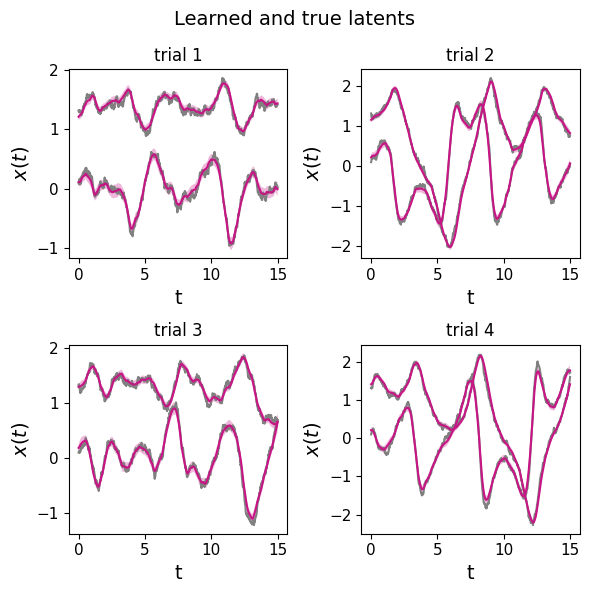

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for i, ax in enumerate(axs.ravel()):
    plot_latents_over_time(t_grid, xs[i], latents_cov=None, color='gray', ax=ax, fontsize=fontsize)
    plot_latents_over_time(t_grid, ms_final[i], Ss_final[i], color='mediumvioletred', alpha=0.3, ax=ax, fontsize=fontsize),
    ax.tick_params(axis='both', labelsize=labelsize)
    ax.set_title(f'trial {i+1}')

fig.suptitle("Learned and true latents", fontsize=fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # shift subplot area down so the suptitle doesn’t overlap

fig.tight_layout()
plt.show()

And visualize the learned prior drift function:

In [32]:
f_trans = transform_vector_field(lambda x: fn.drift(drift_params_basis, x, None), dim=latent_dim, P=P, offset=offset)

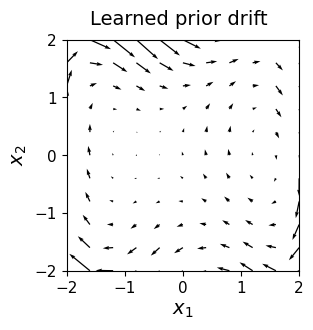

In [33]:
fig, ax = plt.subplots(figsize=(3, 3))
ax = plot_dynamics_and_latents_2d(f_trans, latents=None, ax=ax, n_xpts=11, n_ypts=11, xlim=(-2, 2), ylim=(-2, 2), fontsize=fontsize)
ax.tick_params(axis='both', labelsize=labelsize)

fig.suptitle('Learned prior drift', fontsize=fontsize)
plt.show()